# Mini-projet n°1 - Chats ou Chiens ?

Dans ce projet, nous allons étudier, classifier et segmenter les images du jeu de données Oxford-IIIT Pet Dataset. Ce jeu de données comporte des images de chats et chiens de 37 races différentes.

On commence par importer toutes les librairies dont nous auront besoin.

In [1]:
# Utils
import os
#import shutil
import time
import tensorflow as tf
import re

2025-12-07 13:31:16.938665: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 13:31:20.529046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765110681.631892    3815 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765110681.905783    3815 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765110684.534058    3815 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Maths - Stats
#!pip install scikit_posthocs
import numpy as np
import pandas as pd
import random as rd
import scipy.stats as stats
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind, mannwhitneyu,shapiro, kruskal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scikit_posthocs as sp

In [3]:
# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image 

In [4]:
# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121

## Chargement des données

In [5]:
list = "./annotations//list.txt"
image_dir = "./images"

# Chargement des images du dataset
images = [f for f in os.listdir(image_dir) if f.lower().endswith("jpg")]
print("Il y a ", len(images), "images dans le dataset.")

# Chargement des informations (label) des images, avec le fichier list.txt
df = pd.read_csv(
    list,
    sep=r'\s+',          
    comment='#',         
    header=None,         
    usecols=[0, 1, 2], 
    names=['image', # nom de l'image (sans extension)
           'class_id', # identifiant de la classe (race), entre 1 et 37
           'type'] # type d'animal : 1=chat, 2=chien
)
df["image"] = df["image"].apply(lambda x: x + ".jpg")
n_total = len(df)
print(f"Il y a {n_total} images référencées dans list.txt.")

# Vérification du référencement des images
missing_list = sorted(set(images) - set(df["image"])) # images dans le dataset sans entrée dans list.txt
missing_images = sorted(set(df["image"]) - set(images)) # images référencées dans list.txt mais manquantes dans le dataset
print(f"Il y a {len(missing_list)} images dans le dataset sans entrée dans list.txt.")
print(f"Il y a {len(missing_images)} images référencées dans list.txt mais manquantes dans le dataset.")  

pd.set_option('display.max_rows', None)    # affiche toutes les lignes
pd.set_option('display.max_columns', None) # affiche toutes les colonnes
pd.set_option('display.width', None)       # pas de coupure de lignes
pd.set_option('display.max_colwidth', None) # montre le texte entier dans chaque cellule

Il y a  7390 images dans le dataset.
Il y a 7349 images référencées dans list.txt.
Il y a 41 images dans le dataset sans entrée dans list.txt.
Il y a 0 images référencées dans list.txt mais manquantes dans le dataset.


Certaines images existent dans le dossier "images", mais n'ont pas d'entrées dans list.txt. On va donc les faire rentrer dans le jeu de données, en mettant comme identifiant de classe et type la même chose que les autres fichiers commençant par le même nom.

In [6]:
def get_prefix(filename) :
    name = filename.split('.')[0]
    return re.sub(r'_\d+$', '', name)

# Ajout d'informations dans le DataFrame
df["class"] = df["image"].apply(get_prefix)
df["animal"] = df["type"].apply(lambda x: "cat" if x == 1 else "dog")

# Création d'un dictionnaire de classes connues
classes = (
    df.groupby("class")[["class_id", "type"]]
      .first()
      .to_dict(orient="index")
)

# Ajout du référencement des images dans le DataFrame
new_rows = []
for img in missing_list :
    class_name = get_prefix(img)
    if class_name in classes: # Si on ne connait pas, on ne rajoute pas au DataFrame
        class_id = classes[class_name]["class_id"]
        type = classes[class_name]["type"]
        new_rows.append({
            "image": os.path.splitext(img)[0],
            "class_id": class_id,
            "type": type,
            "class": class_name,
            "animal": "cat" if type == 1 else "dog"
        })

print(f"{len(new_rows)} nouvelles lignes créées.")
df_new = pd.DataFrame(new_rows)
df_full = pd.concat([df, df_new], ignore_index=True)
df_full["image"] = df_full["image"].apply(
    lambda x: x + ".jpg" if not x.lower().endswith(".jpg") else x
)

missing_images = sorted(set(images) - set(df_full["image"]))
print(f"Il y a maintenant {len(missing_images)} images du dataset qui ne sont pas référencées dans le DataFrame.")


df_full.head()

41 nouvelles lignes créées.
Il y a maintenant 0 images du dataset qui ne sont pas référencées dans le DataFrame.


image  class_id  type       class animal
0  Abyssinian_100.jpg         1     1  Abyssinian    cat
1  Abyssinian_101.jpg         1     1  Abyssinian    cat
2  Abyssinian_102.jpg         1     1  Abyssinian    cat
3  Abyssinian_103.jpg         1     1  Abyssinian    cat
4  Abyssinian_104.jpg         1     1  Abyssinian    cat

In [7]:
# Nettoyage 
del(df)
df = df_full
del(new_rows)
del(df_new)
del(df_full)

## Analyse exploratoire

### Etude de la répartition par race et par type

In [8]:
df["class"] = df["class"].astype("str")
df["animal"] = df["animal"].astype("str")
df.dtypes

image       object
class_id     int64
type         int64
class       object
animal      object
dtype: object

In [9]:
nb_images = len(df)
n_class = df["class"].nunique()
n_class_cat = df[df["animal"] == "cat"]["class"].nunique()
n_class_dog = df[df["animal"] == "dog"]["class"].nunique()
nb_cat = len(df[df["animal"] == "cat"])
nb_dog = len(df[df["animal"] == "dog"])

print(f"Il y a {n_class} races différentes dans le dataset, pour {nb_images} images.")
print(f"Il y a {n_class_cat} races de chats et {n_class_dog} races de chiens.")
print(f"Cela représente {nb_cat} images de chats et {nb_dog} images de chiens.")


Il y a 37 races différentes dans le dataset, pour 7390 images.
Il y a 12 races de chats et 25 races de chiens.
Cela représente 2400 images de chats et 4990 images de chiens.


/tmp/ipykernel_4570/158086272.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_2.values, y=counts_2.index, palette="pastel", ax=axes[0,1])


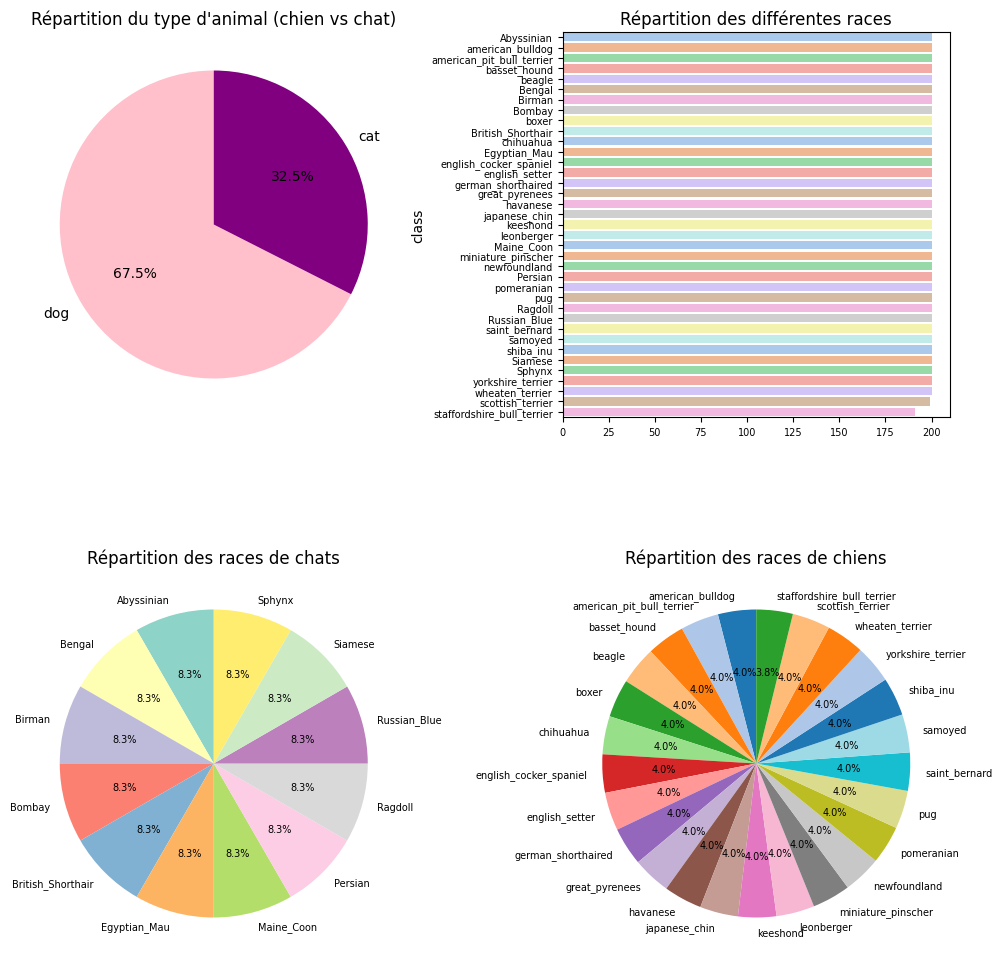

In [14]:
# Nombre d’images par type d'animal : chien vs chat
counts_1 = df["animal"].value_counts()

# Nombre d’images par race
counts_2 = df["class"].value_counts()

# Parmi les chats, répartition des races
counts_3 = df[df["animal"] == "cat"]["class"].value_counts()
counts_3 = counts_3[counts_3 > 0]
labels_cats =  [c for c in counts_3.index if counts_3[c] > 0]
palette_cat = sns.color_palette("Set3", n_colors=len(counts_3))

# Parmi les chiens, répartition des races
counts_4 = df[df["animal"] == "dog"]["class"].value_counts()
counts_4 = counts_4[counts_4 > 0]
labels_dogs =  [c for c in counts_4.index if counts_4[c] > 0]
palette_dog = sns.color_palette("tab20", n_colors=len(counts_4))

# Affichage des graphiques
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

axes[0,0].pie(counts_1, labels=counts_1.index, autopct='%1.1f%%', startangle=90, colors=["pink", "purple"])
axes[0,0].set_title("Répartition du type d'animal (chien vs chat)")

sns.barplot(x=counts_2.values, y=counts_2.index, palette="pastel", ax=axes[0,1])
axes[0,1].set_title("Répartition des différentes races")
axes[0,1].tick_params(axis='x', labelsize=7)
axes[0,1].tick_params(axis='y', labelsize=7) 

axes[1,0].pie(counts_3, labels=labels_cats, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 7}, colors=palette_cat)
axes[1,0].set_title("Répartition des races de chats")

axes[1,1].pie(x=counts_4,  labels=counts_4.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 7}, colors=palette_dog)
axes[1,1].set_title("Répartition des races de chiens")

plt.tight_layout
fig.subplots_adjust(hspace=0.4, wspace=0.4)  

plt.show()


Dans ce dataset, il y a beaucoup plus de chiens (67.5%) que de chats (32.5%). Malgré tout, les différentes races sont dans l'ensemble bien réparties puisqu'il y a 200 images pour chaque race, à l'exception de la race "staffordshire_bull_terrier", qui comporte un tout petit peu moins de 200 individus. Lorsque l'on regarde la répartion des 12 races de chats parmis les chats, elles sont parfaitement équilibrées. Il en va de même pour les chiens, à l'exception du "staffordshire_bull_terrier" qui représente 3.8% des races de chien (contre 4% pour les autres races).

### Vérification de la cohérence et la qualité des masques de segmentation

Un masque de segmentation est un masque de la même taille que l'image, qui va nous permettre d'avoir l'information du sujet de l'image. En effet, le masque va donner à chaque pixel de l'image une valeur parmi ces trois : 
- 1 si le pixel appartient au premier plan de l'image, soit l'animal dans notre cas 
- 2 si le pixel appartient à l'arrière-plan de l'image 
- 3 si le pixel n'est pas classifié.

Les masques de segmentation se trouvent dans le dossier *annotations/trimaps*. Nous allons donc regarder sur un petit jeu de données, sélectionné aléatoirement parmi notre dataset ce que donne le masque de segmentation. 


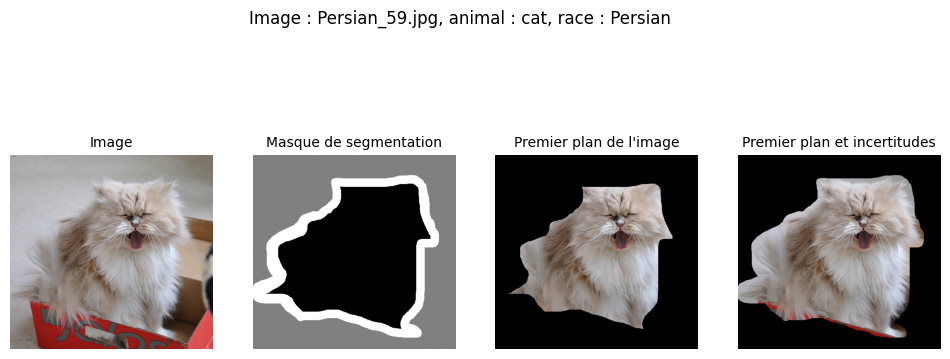

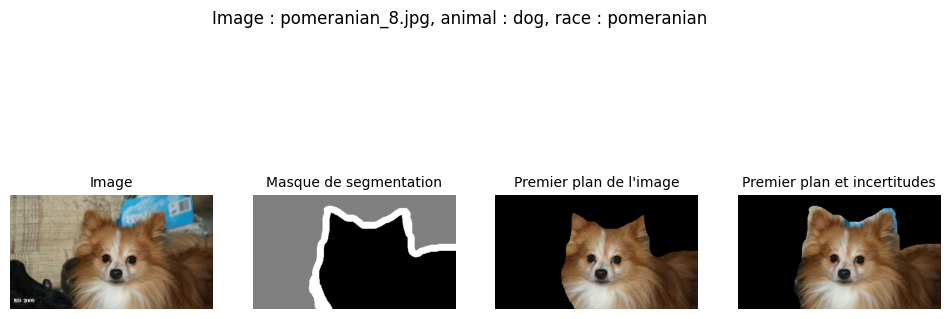

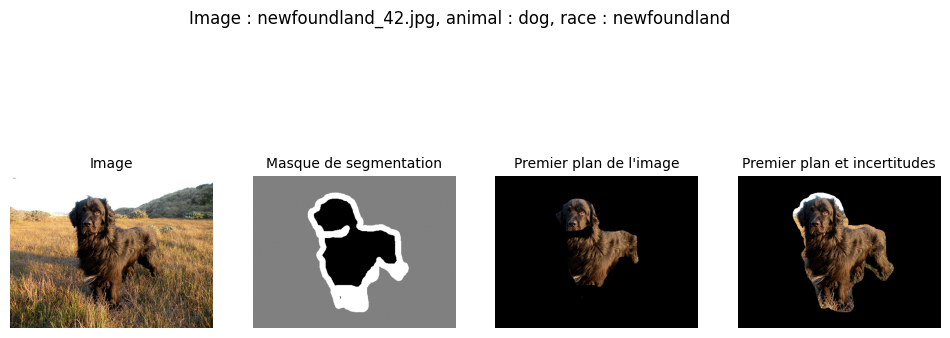

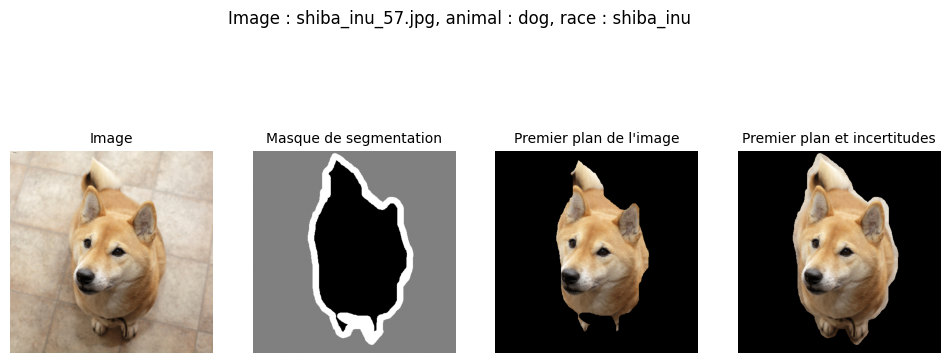

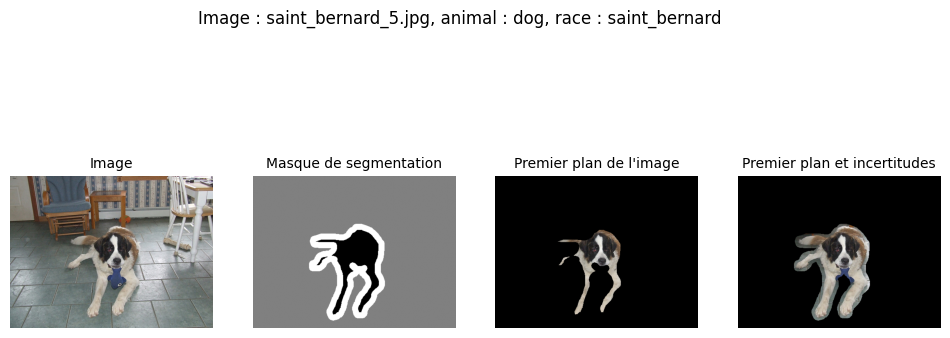

In [10]:
path_images = "./images/"
path_masks = "./annotations/trimaps/"

n = 5

for i in range(5): 
    # Sélection aléatoire d'une image
    filename = rd.choice(df['image'])

    # Chargement de l'image et du masque
    img = np.array(Image.open(path_images + filename))
    mask = np.array(Image.open(path_masks + filename.replace('.jpg', '.png')))

    # Image avec le masque appliqué (seulement le corps de l'animal)
    img_foreground = img.copy()
    img_foreground[mask != 1] = 0  

    # Image avec le masque appliqué (corps de l'animal + zone d'incertitude)
    img_background = img.copy()
    img_background[mask == 2] = 0

    fig, axes = plt.subplots(1, 4, figsize=(12, 5))
    fig.suptitle(f"Image : {filename}, animal : {df[df['image'] == filename]['animal'].values[0]}, race : {df[df['image'] == filename]['class'].values[0]}")

    axes[0].imshow(img)
    axes[0].set_title("Image", fontsize=10)
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Masque de segmentation", fontsize=10)
    axes[1].axis("off")

    axes[2].imshow(img_foreground)  
    axes[2].set_title("Premier plan de l'image", fontsize=10)
    axes[2].axis("off")

    axes[3].imshow(img_background)
    axes[3].set_title("Premier plan et incertitudes", fontsize=10)
    axes[3].axis("off")

    plt.show()

Cela nous permet de vérifier que les masques sont cohérents avec l'image. Cependant, pour certaines photos, la zone d'incertitude peut être assez grande. C'est notamment le cas lorsque l'animal est de la même couleur que l'arrière plan, qu'il est caché par un objet, qu'il a des moustaches ou un collier. 

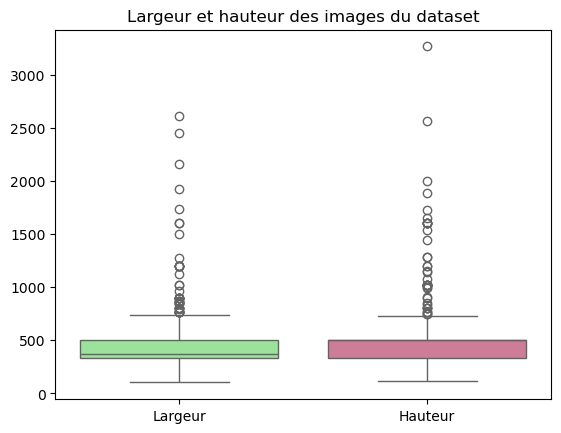

In [19]:
img_size = np.zeros((df.shape[0],2))
for i, filename in enumerate(df['image']) :
    img = img_to_array(load_img(path_images + filename) )
    img_size[i,:] = img.shape[:2]

plt.figure()
ax = sns.boxplot(img_size, palette = ['lightgreen', 'palevioletred'])
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['Largeur', 'Hauteur'])
plt.title("Largeur et hauteur des images du dataset")
plt.show()

On peut voir que les hauteurs et largeurs des images sont bien différentes. Pour la suite, on va les faire passer dans des réseeau de convolution. Il est donc intéressant d'avoir des images de même taille. 

## Classification binaire

Le premier objectif est de faire une classification binaire : à partir d'une photo, le but est de déterminer si elle montre un chat ou un chien.

### Pré - traitement des données

Dans un premier temps, nous séparons le jeu de données en un jeu de données pour l'entrainement, un pour la validation et un dernier qui sera utilisé pour tester le modèle à la fin.

In [11]:
N_train = 5200 # taille du jeu d'entrainement
N_validation = 1400 # taille du jeu de validation

print("Pourcentage des données utilisées pour l'entrainement : ", N_train/len(df))
print("Pourcentage des données utilisées pour la validation : ", N_validation/len(df))
print("Pourcentage des données utilisées pour le test : ", (len(df) - N_train - N_validation)/len(df))

# Séparation des données en un jeu de données d'entrainement (80%) et un jeu de données de test (20%)
test_df, train_df = train_test_split(df, test_size=N_train)
test_df, validation_df = train_test_split(test_df, test_size=N_validation)

Pourcentage des données utilisées pour l'entrainement :  0.7036535859269283
Pourcentage des données utilisées pour la validation :  0.18944519621109607
Pourcentage des données utilisées pour le test :  0.10690121786197564


In [12]:
# Vérification de la répartition des chiens et des chats dans les deux jeux de données
ratio_test = test_df['animal'].value_counts(normalize=True) * 100
ratio_train = train_df['animal'].value_counts(normalize=True) * 100
ratio_validation = validation_df['animal'].value_counts(normalize=True) * 100

print("Part de chien et chat dans les données d'entrainement")
print(ratio_train)
print("Part de chien et chat dans les données de test")
print(ratio_test)
print("Part de chien et chat dans les données de validation")
print(ratio_validation)

Part de chien et chat dans les données d'entrainement
animal
dog    67.442308
cat    32.557692
Name: proportion, dtype: float64
Part de chien et chat dans les données de test
animal
dog    69.367089
cat    30.632911
Name: proportion, dtype: float64
Part de chien et chat dans les données de validation
animal
dog    66.785714
cat    33.214286
Name: proportion, dtype: float64


Les trois jeux de données (entraînement, test et validation) sont plutôt bien équilibrés : il y a quasiment la même proportion de chat et de chien dans les deux. Ces proportions se rapprochent également des 67.5% de chiens et 32.5% de chats présents dans le dataframe initial. 

Passons maintenant au redimensionnement des images. Il faut être vigilent à ce que la variable $\textit{batch\_size}$ soit un diviseur de $N_{\text{train}}$ et $N_{\text{test}}$, qui sont respectivement les tailles du jeu d'entraînement et de validation.

Remarque : il est primordial ici d'ajouter "shuffle=False" dans le test_generator car sinon pour la visualisation, on va prédire sur le générateur (donc un ordre désordonné du df) et les images plots vont (comparaison) sont sur le df de base donc forcement ca sera faux.


In [24]:
img_width = 128
img_height = 128
batch_size = 20 # Diviseur de N_train et N_validation

# Images d'entrainement
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Images de validation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False  #pour l'evaluation
)

# Images de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False   # pour garder les bons indices : les images sont chargées dans l’ordre exact du dataframe
)

Found 5200 validated image filenames belonging to 2 classes.
Found 1400 validated image filenames belonging to 2 classes.
Found 790 validated image filenames belonging to 2 classes.


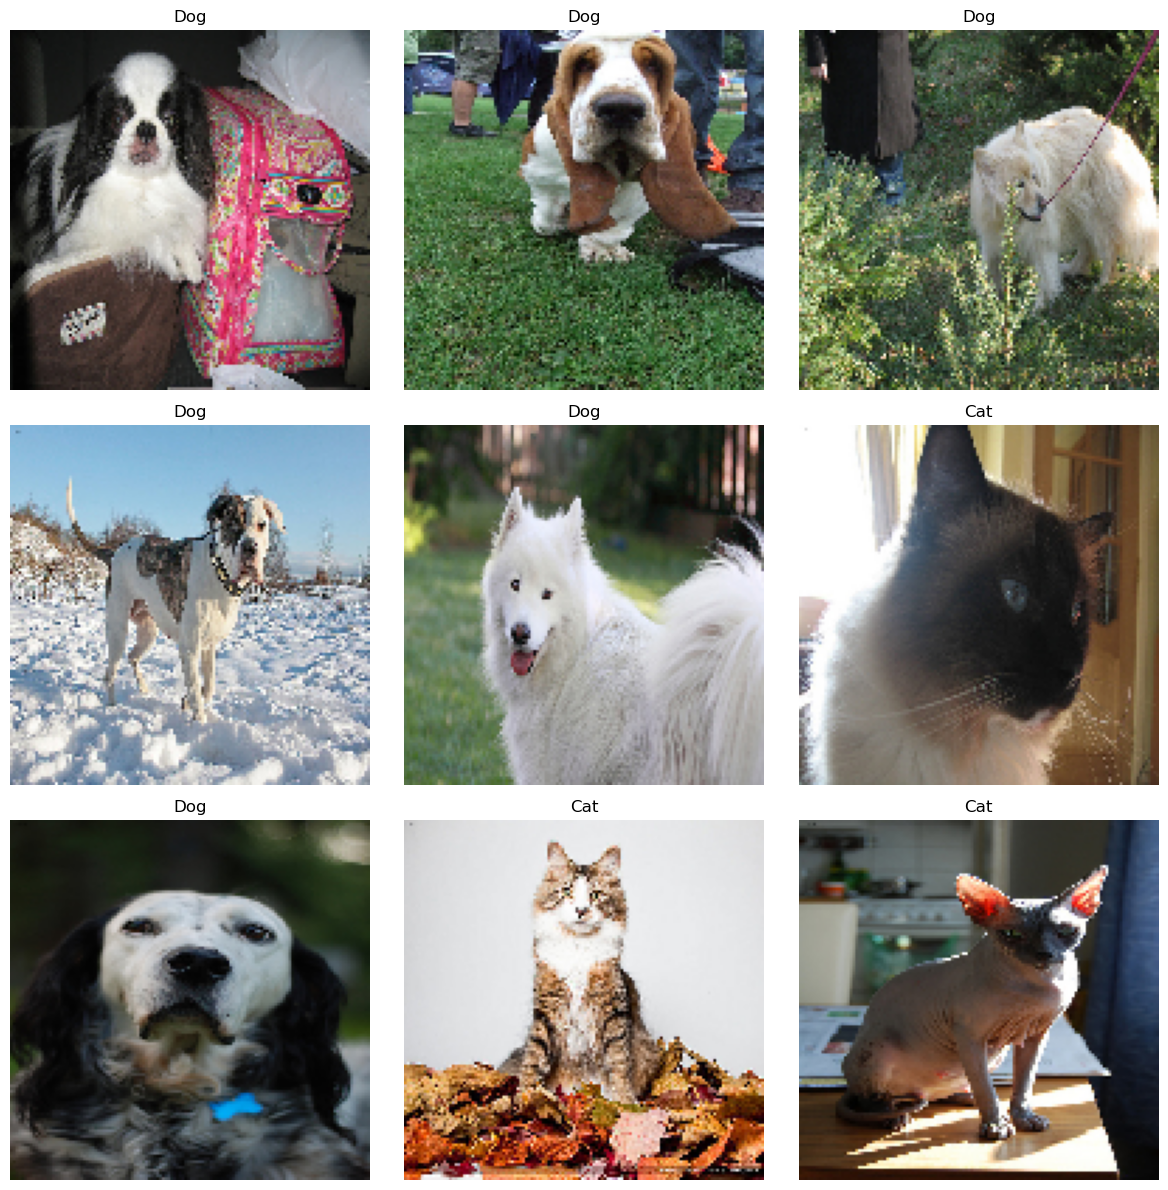

In [23]:
labels = {0: 'Cat', 1: 'Dog'}

# Visualisation de quelques images d'entrainement, redimensionnées
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in train_generator:
        img = x_batch[0]
        plt.title(labels.get(y_batch[0]))
        plt.imshow(img)
        plt.axis('off')
        plt.grid(False)
        break
plt.tight_layout()
plt.show()

### Première approche : réseau de convolution simple

Une première approche pour notre problème est d'utiliser un réseau convolutif. Nous allons construire une version simplifiée de AlexNet. 


Les trois premiers blocs de ce réseau sont de la forme :
- Une couche de convolution, avec des filtres de taille $3 \times 3$ filtres et qui utilise la fonction d'activation $\texttt{Relu}$. Le premier a 32 filtres, le deuxième 64 et le dernier 96
- Une couche de MaxPooling, avec une fenêtre de $2 \times 2$

A la suite de ces trois blocs, on trouve :
- Une couche flatten, afin que les canaux puissent être lus par le réseau de neuronne 
- Une couche dense avec 64 neuronnes, qui utilise la fonction d'activation $\texttt{Relu}$ 
- Une couche dropout, qui met à 0 50% des sorties de la couche précédente. Cela permet une certaine régularisation
- Une couche dense avec un neuronne et une couche d'activation $\texttt{Sigmoid}$ 

In [14]:
# Création du modèle 
 
cnn_simple = Sequential()
cnn_simple.add(Input(shape=(img_width,img_height,3)))

cnn_simple.add(Conv2D(32, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(64, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(96, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Flatten())

cnn_simple.add(Dense(64, activation='relu'))
cnn_simple.add(Dropout(0.5))
cnn_simple.add(Dense(1, activation='sigmoid'))

I0000 00:00:1765110779.155046    3815 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13842 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation, pci bus id: 0000:55:00.0, compute capability: 8.9


In [25]:
# Entraînement du modèle
cnn_simple.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

epochs = 10

t_learning_cnn_simple = time.time()
cnn_simple_history = cnn_simple.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_cnn_simple = time.time() - t_learning_cnn_simple

print("Temps d'apprentissage pour %d epochs : %d secondes" % (epochs, t_learning_cnn_simple))

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 79s 284ms/step - accuracy: 0.6690 - loss: 0.6034 - val_accuracy: 0.6921 - val_loss: 0.5509
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 75s 289ms/step - accuracy: 0.7027 - loss: 0.5471 - val_accuracy: 0.7114 - val_loss: 0.5376
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 70s 269ms/step - accuracy: 0.7402 - loss: 0.5171 - val_accuracy: 0.7307 - val_loss: 0.5172
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 70s 270ms/step - accuracy: 0.7788 - loss: 0.4726 - val_accuracy: 0.7407 - val_loss: 0.5196
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 99s 383ms/step - accuracy: 0.7942 - loss: 0.4326 - val_accuracy: 0.7686 - val_loss: 0.4791
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 136s 525ms/step - accuracy: 0.8188 - loss: 0.3934 - val_accuracy: 0.7800 - val_loss: 0.4623
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 121s 464ms/step - accuracy: 0.8363 - loss: 0.3644 - val_accuracy: 0.7843 - val_loss: 0.4675
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 247s 952ms/step - accuracy: 0.8573 - loss

In [25]:
# Fonctions utiles pour analyser les résultats

def prediction(model, train_generator, validation_generator):
    t_prediction = time.time()
    score_train = model.evaluate(train_generator, verbose=1)
    score_validation = model.evaluate(validation_generator,  verbose=1)
    t_prediction = time.time() - t_prediction

    print('Train accuracy:', score_train[1])
    print('Validation accuracy:', score_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction)
    

def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, color='cadetblue', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, color='sandybrown', label='Validation accuracy')
    plt.title('Training et validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, color='cadetblue', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss, color='sandybrown', label='Validation loss')
    plt.title('Training et validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

260/260 ━━━━━━━━━━━━━━━━━━━━ 37s 142ms/step - accuracy: 0.9238 - loss: 0.1936
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.7929 - loss: 0.5327
Train accuracy: 0.9238461256027222
Validation accuracy: 0.7928571701049805
Time Prediction: 50.20 seconds


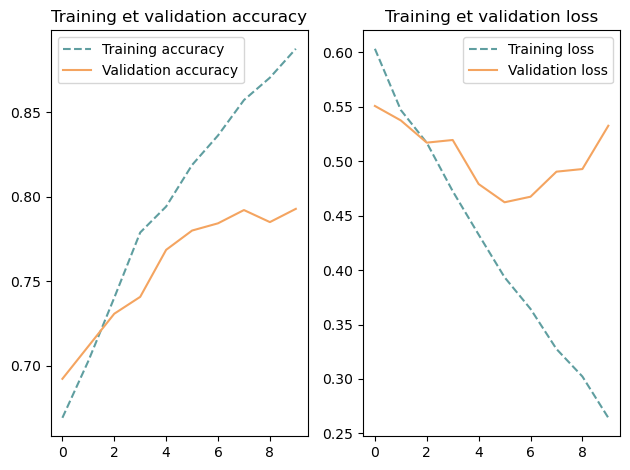

In [27]:
prediction(cnn_simple, train_generator, validation_generator)
plot_training_analysis(cnn_simple_history)

La précision obtenue est plutôt correcte : 82% pour les données de validation, et 95% pour les données d'entraînement. Cependant, on observe un surapprentissage clair : alors qu'à la moitié de l'apprentissage, les courbes de validation se stabilisent (cesse d'augmenter pour l'accuracy, de diminuer pour la loss), les courbes pour le training, elles, continuent d'évoluer. Une solution pour pallier ce problème est de faire de l'augmentation de data.

### CNN simple avec data augmentation

Afin d'éviter l'overfitting, une solution consiste à utilise l'augmentation de données. En effet, en transformant les images d'apprentissage (rotation, décalage...), on a un jeu de données bien plus grand, ce qui peut limiter le surapprentissage. On pourra ensuite suivre la même démarche que précédemment.

In [26]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size=(img_width,img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

#train_generator_eval = train_datagen.flow_from_dataframe(  #utilisé seulement pour l'evaluation lorsqu'il y a data augmentation
#    train_df,
#    path_images,
#    x_col='image',
#    y_col='animal',
#    target_size=(img_width, img_height),
#    class_mode='binary',
#    batch_size=batch_size,
#    shuffle=False
#)

Found 5200 validated image filenames belonging to 2 classes.
Found 5200 validated image filenames belonging to 2 classes.


In [27]:
cnn_simple = Sequential()
cnn_simple.add(Input(shape=(img_width,img_height,3)))

cnn_simple.add(Conv2D(32, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(64, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(96, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Flatten())

cnn_simple.add(Dense(64, activation='relu'))
cnn_simple.add(Dropout(0.5))
cnn_simple.add(Dense(1, activation='sigmoid'))

epochs = 10

cnn_simple.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_cnn_simple_augmented = time.time()

cnn_simple_augmented_history = cnn_simple.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)

t_learning_cnn_simple_augmented = time.time() - t_learning_cnn_simple_augmented

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn_simple_augmented))

/home/roumazei/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.6684 - loss: 0.6310 - val_accuracy: 0.6679 - val_loss: 0.5925
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.6763 - loss: 0.5981 - val_accuracy: 0.6729 - val_loss: 0.6364
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.6775 - loss: 0.5769 - val_accuracy: 0.6779 - val_loss: 0.6911
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.7022 - loss: 0.5641 - val_accuracy: 0.6936 - val_loss: 0.5718
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.7071 - loss: 0.5554 - val_accuracy: 0.7043 - val_loss: 0.6042
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.7135 - loss: 0.5640 - val_accuracy: 0.7471 - val_loss: 0.5321
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.7296 - loss: 0.5435 - val_accuracy: 0.6993 - val_loss: 0.5781
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.7356 - loss: 0.5320 - 

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.7400 - loss: 0.5458
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7452 - loss: 0.5753
Train accuracy: 0.745769202709198
Validation accuracy: 0.7371428608894348
Time Prediction: 16.75 seconds


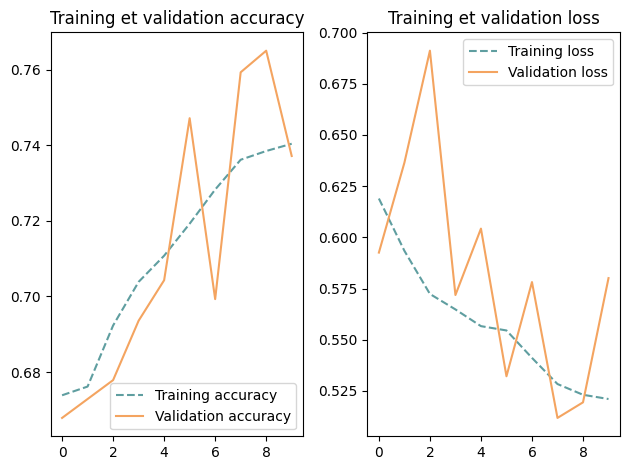

In [28]:
prediction(cnn_simple, train_generator, validation_generator)
plot_training_analysis(cnn_simple_augmented_history)

On remarque que l'overfitting a diminué. En effet, les courbes suivent désormais la même trajectoire. De plus, les précisions obtenues pour les données d'apprentissage et de validation sont du même ordre de grandeur. Même si ces résultats sont corrects (75 à 80% de précision), ils peuvent être améliorés. Une solution consiste à utiliser le Transfer Learning.

### Transfer Learning avec augmentation de données

Le Transfer Learning consiste à utiliser un réseau déjà entraîné pour notre problème. Cela permet de mieux détecter les formes de l'image, et ainsi de mieux distinguer les chats et les chiens. On utilise ici VGG16, qui est composé de 5 blocs de convolution puis d'un MLP classique.Nous allons garder les poids du réseau de convolution, et construire notre propre MLP ensuite.

In [29]:
conv_base = VGG16(
    weights = 'imagenet', # On garde les poids de l'entraînement sur le jeu de données ImageNet
    include_top = False,  # On ne garde pas la partie Dense
    input_shape = (img_width, img_height, 3)
)

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Création du réseau en ajoutant un MLP après le réseau de convolution VGG16
vgg_combined = Sequential()
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(1, activation='sigmoid'))

conv_base.trainable = False # On fige les poids de VGG

vgg_combined.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [31]:
# Apprentissage 

epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined = time.time()
vgg_combined_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined = time.time() - t_learning_vgg_combined

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined))

Epoch 1/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.7499 - loss: 0.5116 - val_accuracy: 0.8457 - val_loss: 0.3291
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.8195 - loss: 0.3890 - val_accuracy: 0.8500 - val_loss: 0.3317
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.8392 - loss: 0.3623 - val_accuracy: 0.8907 - val_loss: 0.2704
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.8433 - loss: 0.3427 - val_accuracy: 0.8693 - val_loss: 0.2792
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.8467 - loss: 0.3395 - val_accuracy: 0.8843 - val_loss: 0.2619
Learning time for 5 epochs : 119 seconds


260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9009 - loss: 0.2346
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8891 - loss: 0.2519
Train accuracy: 0.9042307734489441
Validation accuracy: 0.8842856884002686
Time Prediction: 16.16 seconds


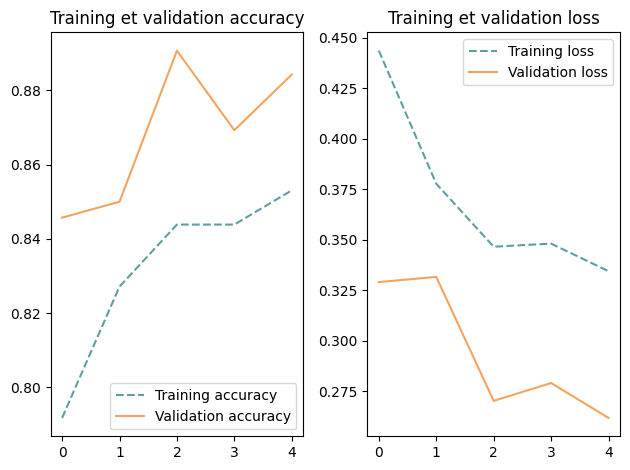

In [35]:
prediction(vgg_combined, train_generator, validation_generator)
plot_training_analysis(vgg_combined_history)

Les précision obtenues sont bien meilleures que précédemment (environ 90%). On peut essayer de les améliorer en faisant un apprentissage sur les poids du réseau VGG.  

Nous allons libérer les poids du dernier bloc de convolution de VGG pour qu'il soit libre pour l'apprentissage. On espère ainsi que VGG s'adaptera à notre problème et qu'on aura des meilleurs résultats que précédemment. 

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:15]:
    layer.trainable = False # On fige les poids des 4 premiers blocs de convolution de VGG

In [ ]:
# Apprentissage 
 
epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=1e-4), # Learning rate plus faible pour ne pas écraser ce qui a été appris précédemment
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned = time.time()
vgg_combined_tuned_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned = time.time() - t_learning_vgg_combined_tuned

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned))

In [ ]:
prediction(vgg_combined, train_generator, validation_generator)
plot_training_analysis(vgg_combined_tuned_history)

Les résultats obtenus sont bien meilleurs que précédemment, jusqu'à atteindre 95% de précision. La fonction perte décroit elle aussi de manière significative par rapport à l'étape précédente. Essayons maintenant de faire un entraînement sur tous les poids du modèle. 

In [ ]:
conv_base.trainable = True # On libère tous les poids du modèle

In [ ]:
# Apprentissage 
 
epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=1e-5), # Learning rate plus faible pour ne pas écraser ce qui a été appris précédemment
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned2 = time.time()
vgg_combined_tuned_history2 = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned2 = time.time() - t_learning_vgg_combined_tuned2

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned))

In [ ]:
prediction(vgg_combined, train_generator, validation_generator)
plot_training_analysis(vgg_combined_tuned_history2)

La précision obtenue avec ce dernier modèle monte jusqu'à 98%, ce qui est bien mieux. De même, la fonction perte a encore diminué de manière significative. Les fonctions de précision et de perte n'évoluant plus beaucoup, il est maintenant temps de tester ce modèle final.

### Test du modèle final

In [ ]:
test_prediction = vgg_combined.predict(test_generator)
score_test = vgg_combined.evaluate(test_generator)
print('Test accuracy:', score_test[1])

In [ ]:
fig = plt.figure(figsize=(10,10))

test_imgs_idx = np.random.randint(low=0, high=test_df.shape[0], size=(9,))

for i, idx in enumerate(test_imgs_idx):
    filename = test_df['image'].iloc[idx]
    img = img_to_array(load_img(path_images + filename) ) / 255
    pred = test_prediction[idx][0]
    
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(img, interpolation='nearest')
    color = "seagreen"
    type = test_df['animal'].iloc[idx]
    
    if pred >0.5:
        title = "Probabilité pour un chien : %.1f" % (pred*100)
        if type == 'cat':
            color = "firebrick"
    else:
        title = "Probabilité pour un chat : %.1f" %((1-pred)*100)
        if type == 'dog':
            color = "firebrick"
    ax.set_title(title, color=color)

plt.tight_layout()
plt.show()

En testant ce modèle sur le jeu de données de test, on obtient une précision de 96%, ce qui est tout à fait correct. En observant les images, on peut observer les erreurs du modèle.

## Classification fine

### Transfer Learning à partir de Vgg16 avec les poids figés

L'objectif ici est de réussir à identifier les différentes races de chiens et chats parmi les 37 disponibles. Une difficulté pourrait se présenter : la confusion de plusieurs races proches.

Je commence par prendre le même architecture de modèle que précédemment : le modèle de transfer learning à partir de VGG16 en figeant les poids.

In [20]:
conv_base = VGG16(
    weights = 'imagenet', # On garde les poids de l'entraînement sur le jeu de données ImageNet
    include_top = False,  # On ne garde pas la partie Dense
    input_shape = (img_width, img_height, 3)
)

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

On ne garde pas la partie dense pour pouvoir ajouter une couche qui correspond à ce qu'on veut résoudre comme problématique.

In [21]:
# Création du réseau en ajoutant un MLP après le réseau de convolution VGG16
vgg_combined_fine = Sequential()
vgg_combined_fine.add(Input(shape=(img_width, img_height, 3)))
vgg_combined_fine.add(conv_base)
vgg_combined_fine.add(Flatten())
vgg_combined_fine.add(Dense(256, activation='relu'))
vgg_combined_fine.add(Dropout(0.5)) 
vgg_combined_fine.add(Dense(37, activation='softmax')) #37 valeurs de sorties car 37 especes 

conv_base.trainable = False # On fige les poids de VGG

vgg_combined_fine.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 37)             │         9,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,821,605 (64.17 MB)

 Trainable params: 2,106,917 (8.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

On redéfinit les générateurs car le porblème ici n'est plus binaire et on ne cherche plus l'animal mais la race qui est indiqué dans le dataset par 'class'.

In [22]:
train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    path_images,
    x_col = 'image',
    y_col = 'class',
    target_size=(img_width,img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path_images,
    x_col = 'image',
    y_col = 'class',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

# Images de validation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    path_images,
    x_col = 'image',
    y_col = 'class',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

# Images de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    path_images,
    x_col = 'image',
    y_col = 'class',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle=False  #on ne mélange pas les images : l'ordre des images dans test_df est gardé
)

Found 5200 validated image filenames belonging to 37 classes.
Found 5200 validated image filenames belonging to 37 classes.
Found 1400 validated image filenames belonging to 37 classes.
Found 790 validated image filenames belonging to 37 classes.


Pour le générateur de test, il est primordial de mettre shuffle à False pour la visualisation d'images à la fin lors du test. Si cela n'est pas fait, l'image et la prédiction ne correspondront pas ce qui nous donnera des erreurs même si le modèle ne se trompe pas.

In [23]:
# Apprentissage 

epochs = 10

vgg_combined_fine.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined_fine = time.time()
vgg_combined_history = vgg_combined_fine.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_fine = time.time() - t_learning_vgg_combined_fine

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_fine))

Epoch 1/10


/home/roumazei/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-12-06 18:23:29.396988: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1409', 16 bytes spill stores, 16 bytes spill loads



260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.0359 - loss: 3.7242 - val_accuracy: 0.1086 - val_loss: 3.3669
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.0615 - loss: 3.4567 - val_accuracy: 0.1621 - val_loss: 3.1213
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.1004 - loss: 3.2640 - val_accuracy: 0.2243 - val_loss: 2.8889
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.1193 - loss: 3.1321 - val_accuracy: 0.2693 - val_loss: 2.7067
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.1408 - loss: 3.0206 - val_accuracy: 0.2893 - val_loss: 2.5273
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.1745 - loss: 2.9044 - val_accuracy: 0.3386 - val_loss: 2.4819
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.1786 - loss: 2.8475 - val_accuracy: 0.3436 - val_loss: 2.4256
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.1836 - loss: 2.7812 - val_accurac

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.4508 - loss: 2.0771
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3927 - loss: 2.2200
Train accuracy: 0.443461537361145
Validation accuracy: 0.3821428716182709
Time Prediction: 16.65 seconds


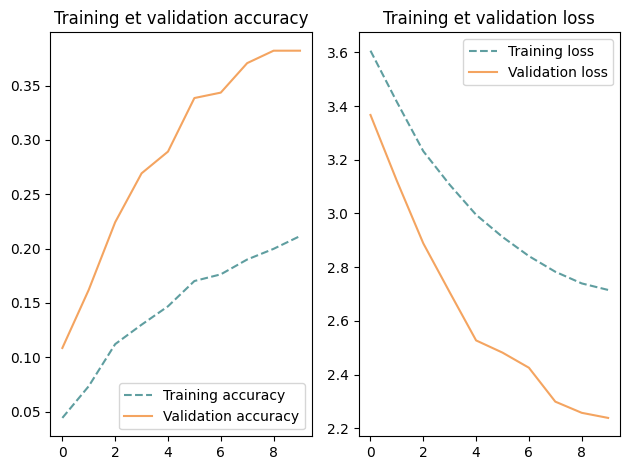

In [26]:
prediction(vgg_combined_fine, train_generator, validation_generator)
plot_training_analysis(vgg_combined_history)

Les résultats obtenus ne sont pas très bons en terme d'accuracy. Cependant, on observe que les courbes de l'accuracy augmentent et celles de la loss sont décroissantes ce qui nous indique qu'avec un nombre d'epochs plus grand, l'accuracy peut être augmentée et la loss peut être diminuée.

De plus, on observe que l'accuracy(resp la loss) est plus élevée(resp faible) dans le validation set que dans le training set ce qui semble étrange. Cela peut s'expliquer par le fait que l'augmentation de données a été faite seulement sur le training set et non sur le validation set donc le modèle s'entraine sur des images plus compliquées, bruitées et lorsqu'il revient sur des images plus simples il y arrive donc mieux.

On remarque que figer les poids de VGG16 pour la classification binaire a donné des résultats très bons comparés aux nôtres. Cela s'explique par le fait que pour le cas "chat vs chien", les dernières couches du VGG16 contiennent déjà suffisamment d’informations pour séparer ces deux catégories. Or ici, avec 37 classes, nous avons besoin de features subtiles spécifiques à chaque race, que le modèle pré-entraîné sur ImageNet n'arrive pas à capturer : le MLP final n’a pas assez d’informations pour distinguer des différences fines.

Essayons la même chose en libérant les poids du dernier block du modèle VGG16, ainsi, ils seront aussi modifiés et ajustés.

### Libération des poids de VGG16 : fine-tuning 

On implémente de nouveau le modèle en libérant cette fois ci seulement le block5 de VGG16 c'est à dire que seul le block5 pourra voir ses poids ajustés. On prend le dernier block car c'est celui qui capture les détails très spécifiques et donc celui qu'on veut ajuster pour le fine-tuning en gardant les poids des autres blocks qui apprennent les bords, les motifs simples et intermdiaires et les textures.

On rappelle qu'un block représente un ensemble cohérent de couches.

In [ ]:
conv_base_tuned = VGG16(
    weights = 'imagenet', # On garde les poids de l'entraînement sur le jeu de données ImageNet
    include_top = False,  # On ne garde pas la partie Dense
    input_shape = (img_width, img_height, 3)
)

conv_base_tuned.summary()

In [ ]:
# Création du réseau en ajoutant un MLP après le réseau de convolution VGG16
vgg_combined_fine = Sequential()
vgg_combined_fine.add(Input(shape=(img_width, img_height, 3)))
vgg_combined_fine.add(conv_base_tuned)
vgg_combined_fine.add(Flatten())
vgg_combined_fine.add(Dense(256, activation='relu'))
vgg_combined_fine.add(Dense(37, activation='softmax'))

conv_base_tuned.trainable = True #  On autorise le fine-tuning de tout le modèle, pour permettre de modifier individuellement layer.trainable

# On ne fine-tune que les couches du block 5 : toutes les autres sont gelées
for layer in conv_base_tuned.layers:
    if not layer.name.startswith("block5"):
        layer.trainable = False


vgg_combined_fine.summary()

In [ ]:
# Apprentissage 
 
epochs = 10

vgg_combined_fine.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=1e-5), # Learning rate plus faible pour ne pas écraser ce qui a été appris précédemment
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned2 = time.time()
vgg_combined_tuned_history2 = vgg_combined_fine.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned2 = time.time() - t_learning_vgg_combined_tuned2

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned2))

In [ ]:
prediction(vgg_combined_fine, train_generator, validation_generator)
plot_training_analysis(vgg_combined_tuned_history2)

On obtient de meilleurs résultats en libérant les poids du dernier block de VGG16. On observe toujours le même phénomène que précédemment: l'accuracy pour le validation set est plus élevé que le train set. Ces meilleurs résultats s'expliquent par le fait que débloquer certaines couches de VGG16 permet d’adapter les filtres convolutionnels aux différences fines entre races.

Encore une fois, au vu des tendances des courbes, augmenter le nombre d'epochs permettrait d'augmenter légèrement l'accuracy et de diminuer la loss.

## Data transfer learning avec le modèle DenseNet121

Après de la recherche, le modèle DenseNet est apparu comme étant un modèle performant pour la classification fine. On a donc fait de la recherche bibliographique pour voir ce que disaient les articles à ce sujet. 
L'article ci-dessous a pour but de détecter quatre classes de tumeurs cérébrales utilisant l'apprentissage par transfert learning à partir de DenseNet-121. En regardant leurs résultats, on observe une très grande performance du modèle avec 99% d'accuracy sur le test data (comparé à 98,24% pour le modèle VGG16). La différence d'accuracy avec VGG-16 est très fine.

Le lien de l'article est le suivant : https://www.akademiabaru.com/submit/index.php/ard/article/view/6174 

Le modèle DenseNet-121 connecte chaque couche à toutes les couches suivantes, facilitant la propagation des gradients, réutilisant les caractéristiques et réduisant le nombre total de paramètres. En effet, comme chaque couche reçoit les caractéristiques de toutes les couches précédentes, cela permet de mieux capturer les détails fins, essentiels pour distinguer des classes très proches comme les races de chiens et chats.

Le but est donc d'essayer d'obtenir de meilleur résultats qu'avec VGG-16.

In [ ]:
dense_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

dense_model.summary()

In [ ]:
dense_combined_fine = Sequential()
dense_combined_fine.add(Input(shape=(img_width, img_height, 3)))
dense_combined_fine.add(dense_model)
dense_combined_fine.add(Flatten())
dense_combined_fine.add(Dense(256, activation='relu'))
dense_combined_fine.add(Dropout(0.5)) 
dense_combined_fine.add(Dense(37, activation='softmax')) 

dense_model.trainable = False # On fige les poids de DenseNet

dense_combined_fine.summary()

In [ ]:
# Apprentissage 

epochs = 10

dense_combined_fine.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=1e-5),
    metrics = ['accuracy']
)

t_learning_dense_combined_fine = time.time()
dense_combined_history = dense_combined_fine.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_dense_combined_fine = time.time() - t_learning_dense_combined_fine

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_dense_combined_fine))

In [ ]:
prediction(dense_combined_fine, train_generator, validation_generator)
plot_training_analysis(dense_combined_history)


Ces résultats sont légèrement plus satisfaisants en terme d'accuracy pour le training set et bien plus satisfaisants pour le validation set. Le modèle utilisé est légèrement plus intéressant que VGG16. L'écart entre les courbes est bien plus élevé que précédemment ce qui ets assez étrange mais peut s'expliquer de la même façon que précédemment: le training set est plus compliqué que le validation set. 


## Data transfer learning avec le modèle DenseNet121 - fine tuning


In [27]:
dense_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

dense_combined_fine = Sequential()
dense_combined_fine.add(Input(shape=(img_width, img_height, 3)))
dense_combined_fine.add(dense_model)
dense_combined_fine.add(Flatten())
dense_combined_fine.add(Dense(256, activation='relu'))
dense_combined_fine.add(Dropout(0.5)) 
dense_combined_fine.add(Dense(37, activation='softmax')) 

for layer in conv_base.layers:
    if not layer.name.startswith("conv5"):
        layer.trainable = False   # gèle toutes les couches avant le dernier bloc
    else:
        layer.trainable = True    # ne fine-tune que le dernier bloc


dense_combined_fine.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 37)             │         9,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,241,573 (42.88 MB)

 Trainable params: 11,157,925 (42.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [29]:
# Apprentissage 

epochs = 10

dense_combined_fine.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=1e-5),
    metrics = ['accuracy']
)

t_learning_dense_combined_fine = time.time()
dense_combined_history = dense_combined_fine.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_dense_combined_fine = time.time() - t_learning_dense_combined_fine

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_dense_combined_fine))

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 115s 114ms/step - accuracy: 0.0372 - loss: 4.6718 - val_accuracy: 0.1729 - val_loss: 3.1225
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.1009 - loss: 3.3819 - val_accuracy: 0.3757 - val_loss: 2.4626
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.2165 - loss: 2.9135 - val_accuracy: 0.5379 - val_loss: 1.7463
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.3377 - loss: 2.3681 - val_accuracy: 0.6514 - val_loss: 1.2494
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.4431 - loss: 1.9846 - val_accuracy: 0.7121 - val_loss: 0.9995
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.5136 - loss: 1.7205 - val_accuracy: 0.7500 - val_loss: 0.8347
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.5623 - loss: 1.5432 - val_accuracy: 0.7636 - val_loss: 0.7621
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.6005 - loss: 1.3329 

260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8722 - loss: 0.4060
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8005 - loss: 0.6321
Train accuracy: 0.8688461780548096
Validation accuracy: 0.8014285564422607
Time Prediction: 14.22 seconds


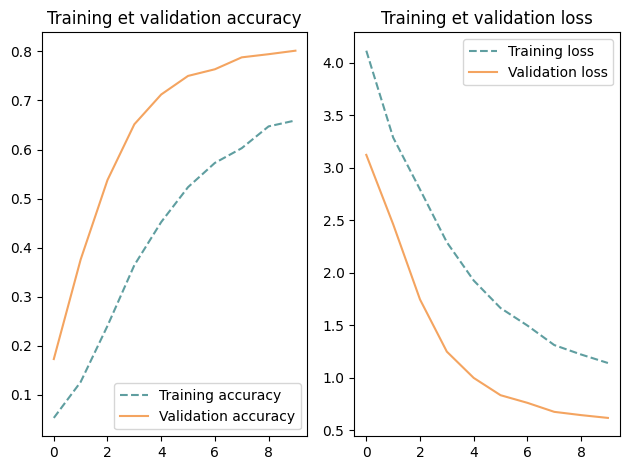

In [30]:
prediction(dense_combined_fine, train_generator, validation_generator)
plot_training_analysis(dense_combined_history)

On obtient de meilleurs résultats en terme d'accuracy

### Test

Je teste sur le meilleur modèle: le modèle basé sur DenseNet-121 avec le fine-tuning.

In [31]:
test_prediction = dense_combined_fine.predict(test_generator)
score_test = dense_combined_fine.evaluate(test_generator)
print('Test accuracy:', score_test[1])

40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 341ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.8392 - loss: 0.5363
Test accuracy: 0.8253164291381836


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step


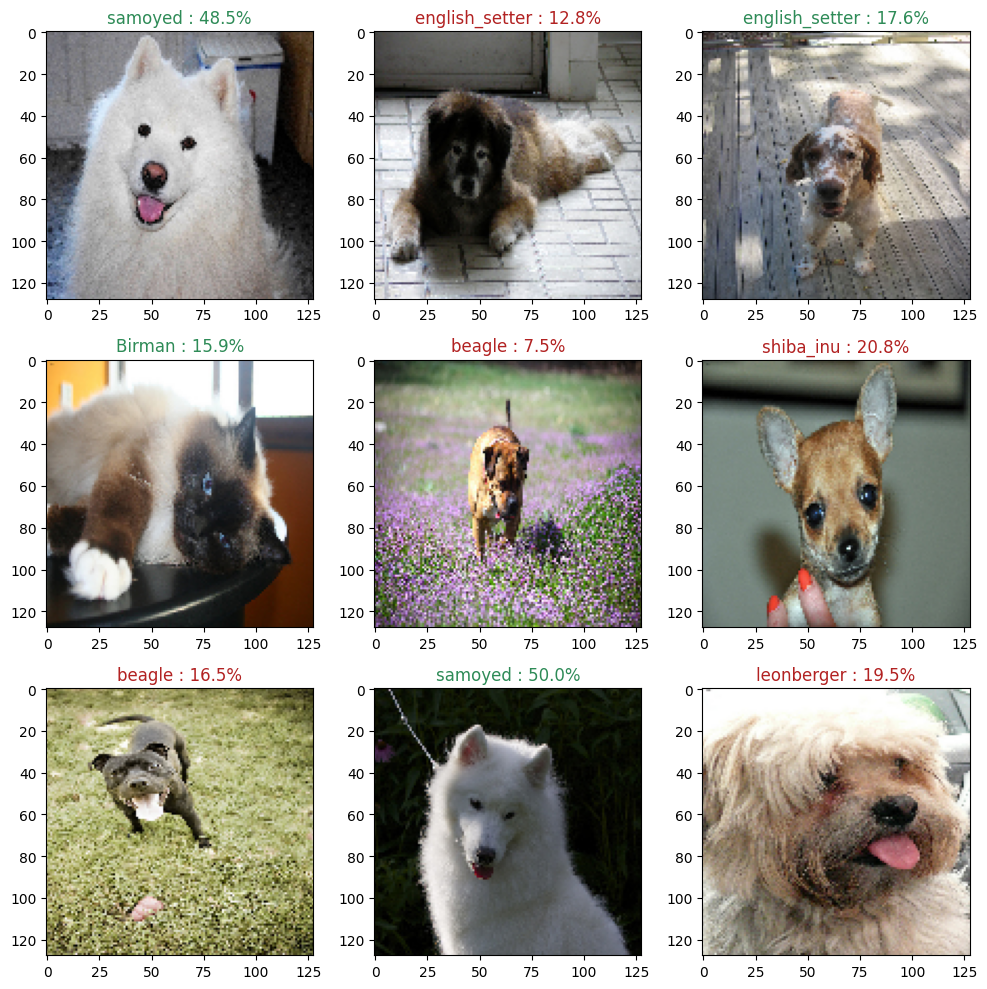

In [32]:
class_names = {v: k for k, v in test_generator.class_indices.items()}

x_batch, y_batch = next(test_generator)
# récupérer toutes les images et labels dans l'ordre exact
X_test, y_test = [], []
for i in range(len(test_generator)):
    x, y = test_generator[i] 
    # x_batch=Contient toutes les images du test set dans l’ordre exact du generator , x_batch.shape = (batch_size, img_width, img_height, 3)
    #y_test.shape = (nb_images, nb_classes), Contient tous les labels one-hot correspondants
    X_test.append(x)  
    y_test.append(y)
X_test = np.vstack(X_test)   #X_test[i] = image envoyée au modèle pour prédiction n°i
y_test = np.vstack(y_test)  #y_test[i] = label exact correspondant à X_test[i]
test_prediction = vgg_combined_fine.predict(X_test)

fig = plt.figure(figsize=(10,10))
indices = np.random.choice(len(X_test), 9, replace=False)

for i, idx in enumerate(indices):
    img = X_test[idx]
    pred = test_prediction[idx]
    #On utilise maintenant le label provenant directement du generator, pas du dataframe original
    pred_class_idx = np.argmax(pred)
    pred_class_prob = np.max(pred)
    true_class_idx = np.argmax(y_test[idx])
    
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(img)
    
    color = "seagreen" if pred_class_idx == true_class_idx else "firebrick"
    title = f"{class_names[pred_class_idx]} : {pred_class_prob*100:.1f}%"
    ax.set_title(title, color=color)

plt.tight_layout()
plt.show()


### Etude de la confusion

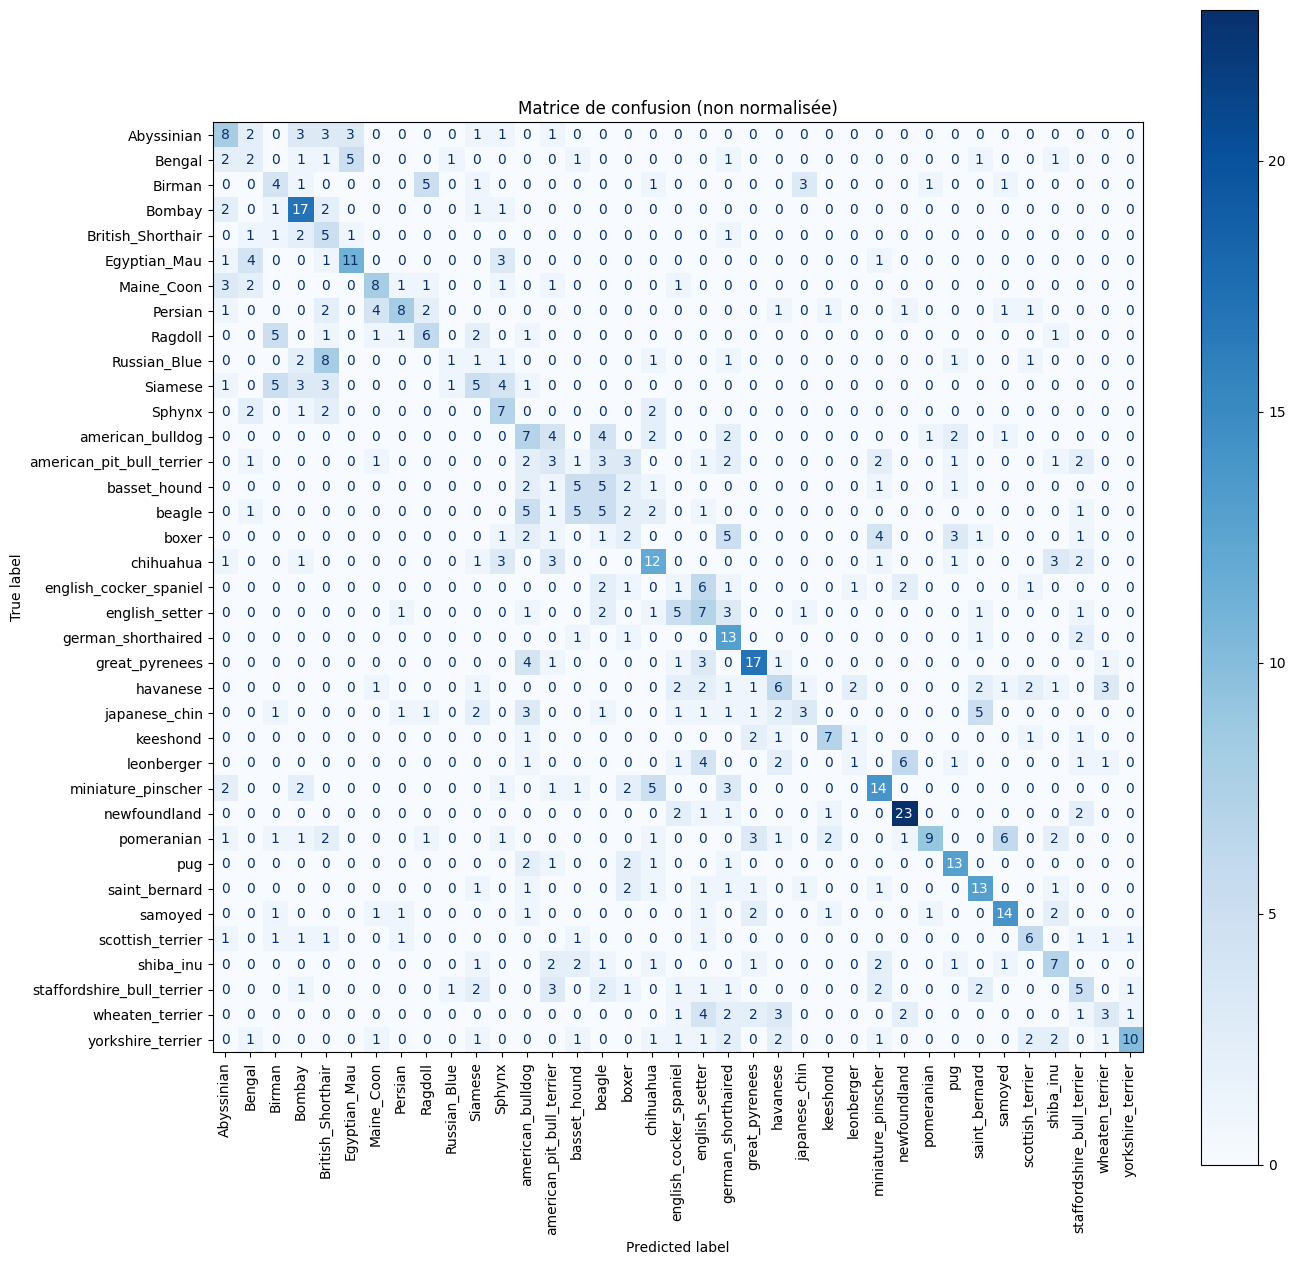

In [33]:
del list

# classes réelles et prédictions
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_prediction, axis=1)

cm = confusion_matrix(y_true, y_pred)

# afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_names.values()))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap='Blues', colorbar=True, values_format='d')
plt.xticks(rotation=90)
plt.title("Matrice de confusion (non normalisée)")
plt.show()

De manière globale, les races sont bien prédites, on observe tout de même des erreurs pour certaines races comme le basset_hound et le beagle qui sont confondues par le modèle, le russian blue avec le british shorthair ainsi que le beagle et l'american bulldog. Ce sont des races qui se ressemblent ce qui est cohérent. Regardons cela de plus près.

#### Pour Basset Hound vs Beagle

Regardons à quoi ils ressemblent.

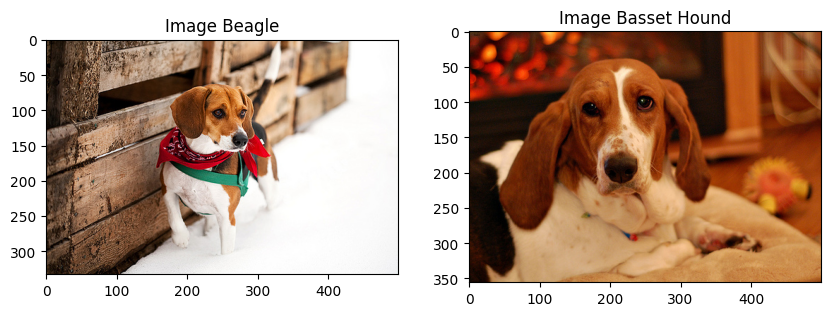

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 ligne, 2 colonnes

aby_df = test_df[test_df['class'] == "beagle"]
filename = aby_df['image'].iloc[4]
img1 = img_to_array(load_img(path_images + filename) ) / 255

axes[0].imshow(img1)
axes[0].set_title("Image Beagle") 

bengal_df = test_df[test_df['class'] == "basset_hound"]
filename2 = bengal_df['image'].iloc[1]
img2 = img_to_array(load_img(path_images + filename2) ) / 255

axes[1].imshow(img2)
axes[1].set_title("Image Basset Hound") 
plt.show()

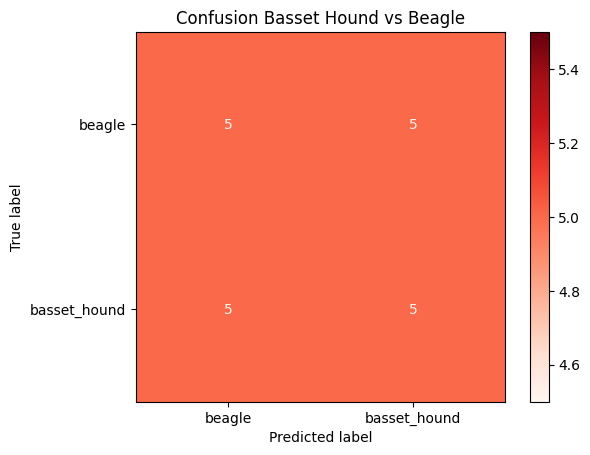

In [38]:
class_to_idx = {v: k for k, v in class_names.items()}  # On inverse pour obtenir {classe: index}
classes_proches = ['beagle', 'basset_hound']
idx_proches = [class_to_idx[c] for c in classes_proches] # On garde en mémoire leurs indices

# y_true et y_pred pour tout le test set
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_prediction, axis=1)

# Filtrer uniquement les images de ces classes
mask = np.isin(y_true, idx_proches)  #retourne un tableau de booléens tq si l'image est aby ou bengal ca retourne True sinon False : sert juste à sélectionner les images dont la vraie classe est l’une des deux races que tu veux analyser
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]


cm_subset = confusion_matrix(y_true_filtered, y_pred_filtered, labels=idx_proches)

# Affichage
disp = ConfusionMatrixDisplay(cm_subset, display_labels=classes_proches)
disp.plot(cmap='Reds', values_format='d')
plt.title("Confusion Basset Hound vs Beagle")
plt.show()

On voit que le modèle se trompe autant qu'il prédit la bonne race. Il a donc 50% de chance de prédire la bonne race ce qui n'est pas optimal mais reste cohérent tout de même au vu de la ressemblance des deux races.

#### Pour Beagle vs American Bulldog

Regardons à quoi ressemble les deux races.

In [ ]:
test_df['class']

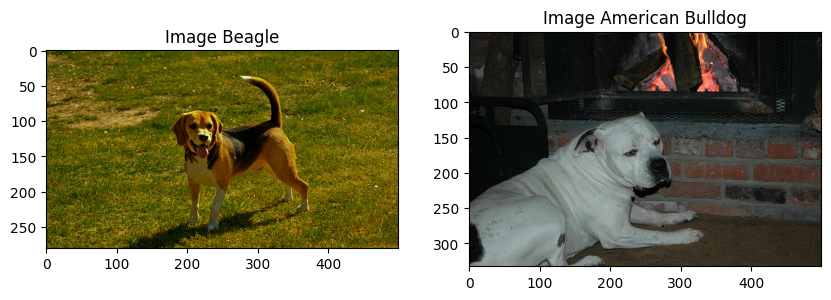

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 ligne, 2 colonnes

beagle_df = test_df[test_df['class'] == "beagle"]
filename = beagle_df['image'].iloc[11]
img1 = img_to_array(load_img(path_images + filename) ) / 255

axes[0].imshow(img1)
axes[0].set_title("Image Beagle") 

american_df = test_df[test_df['class'] == "american_bulldog"]
filename2 = american_df['image'].iloc[10]
img2 = img_to_array(load_img(path_images + filename2) ) / 255

axes[1].imshow(img2)
axes[1].set_title("Image American Bulldog") 
plt.show()

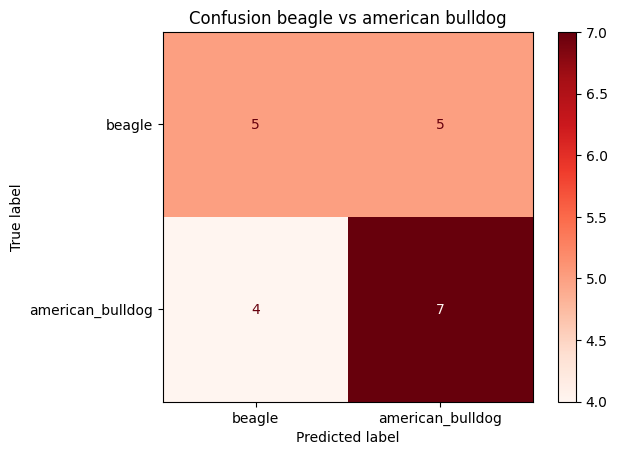

In [50]:
class_to_idx = {v: k for k, v in class_names.items()}
classes_proches = ['beagle', 'american_bulldog']
idx_proches = [class_to_idx[c] for c in classes_proches]

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_prediction, axis=1)
mask = np.isin(y_true, idx_proches)
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]


cm_subset = confusion_matrix(y_true_filtered, y_pred_filtered, labels=idx_proches)

# Affichage
disp = ConfusionMatrixDisplay(cm_subset, display_labels=classes_proches)
disp.plot(cmap='Reds', values_format='d')
plt.title("Confusion beagle vs american bulldog")
plt.show()

Les deux races ne se ressemblent pas tellemtn surtout au niveau des oreilles, malgrès cela, le modèle se trompe assez. En effet, il a légèrement plus tendance à prédire un american bulldog alors que c'est un beagle.

#### Pour Russian blue vs British shorthair

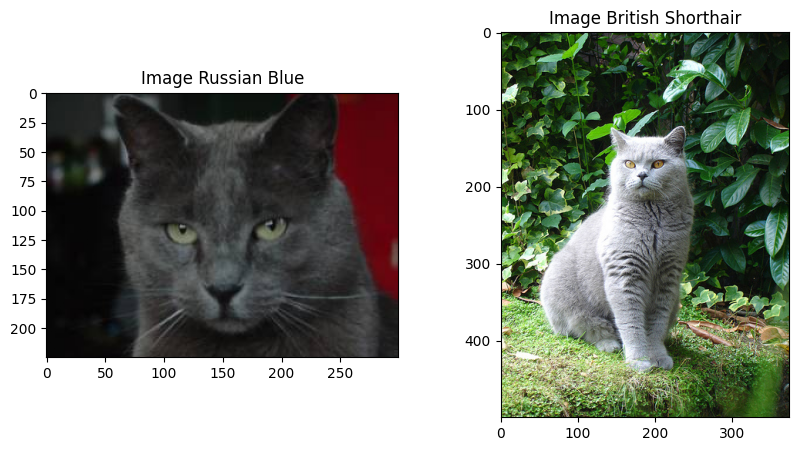

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 ligne, 2 colonnes

russian_df = test_df[test_df['class'] == "Russian_Blue"]
filename = russian_df['image'].iloc[11]
img1 = img_to_array(load_img(path_images + filename) ) / 255

axes[0].imshow(img1)
axes[0].set_title("Image Russian Blue") 

british_df = test_df[test_df['class'] == "British_Shorthair"]
filename2 = british_df['image'].iloc[4]
img2 = img_to_array(load_img(path_images + filename2) ) / 255

axes[1].imshow(img2)
axes[1].set_title("Image British Shorthair") 
plt.show()

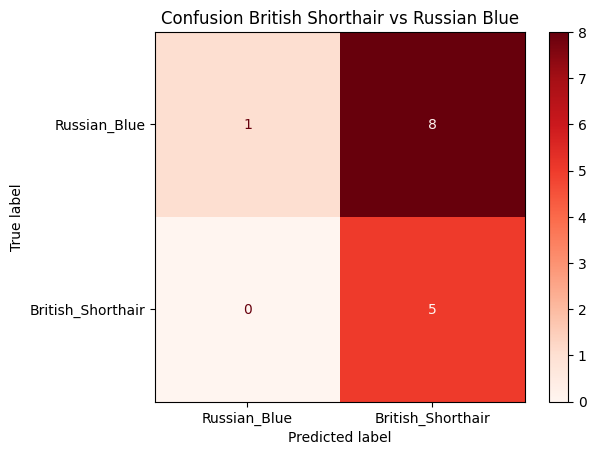

In [53]:
class_to_idx = {v: k for k, v in class_names.items()}
classes_proches = ['Russian_Blue', 'British_Shorthair']
idx_proches = [class_to_idx[c] for c in classes_proches]

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_prediction, axis=1)
mask = np.isin(y_true, idx_proches)
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]


cm_subset = confusion_matrix(y_true_filtered, y_pred_filtered, labels=idx_proches)

# Affichage
disp = ConfusionMatrixDisplay(cm_subset, display_labels=classes_proches)
disp.plot(cmap='Reds', values_format='d')
plt.title("Confusion British Shorthair vs Russian Blue")
plt.show()

Pour ces deux races, le modèle n'arrive pas du tout à prédire correctement le Russian Blue et se trompe en le confondant avec le british shorthair. Il n'est pas du tout performant pour la différence de ces races, très proche en apparence.

### Boxer vs American bulldog

Procédons de manière inverse, regardons la matrice de confusion des deux races.

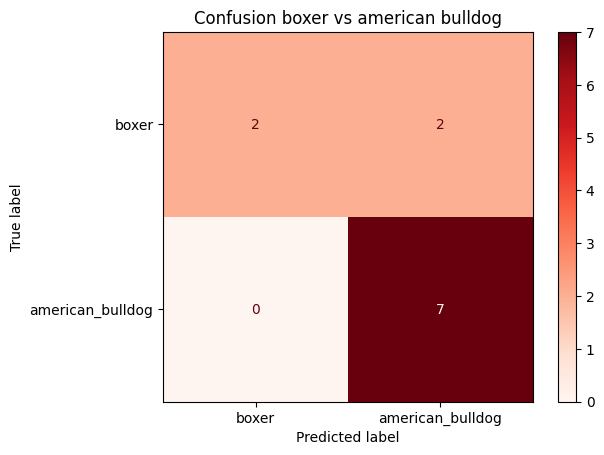

In [67]:
class_to_idx = {v: k for k, v in class_names.items()}
classes_proches = ['boxer', 'american_bulldog']
idx_proches = [class_to_idx[c] for c in classes_proches]

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_prediction, axis=1)
mask = np.isin(y_true, idx_proches)
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]


cm_subset = confusion_matrix(y_true_filtered, y_pred_filtered, labels=idx_proches)

# Affichage
disp = ConfusionMatrixDisplay(cm_subset, display_labels=classes_proches)
disp.plot(cmap='Reds', values_format='d')
plt.title("Confusion boxer vs american bulldog")
plt.show()

Ici on remarque que le modèle fait un peu plus d'erreur pour ces deux races: il prédit un americain lorsque le chien est un beagle. Il arrive bien à prédire l'american mais pas le beagle. Regardons à quoi ressemble ces chiens.

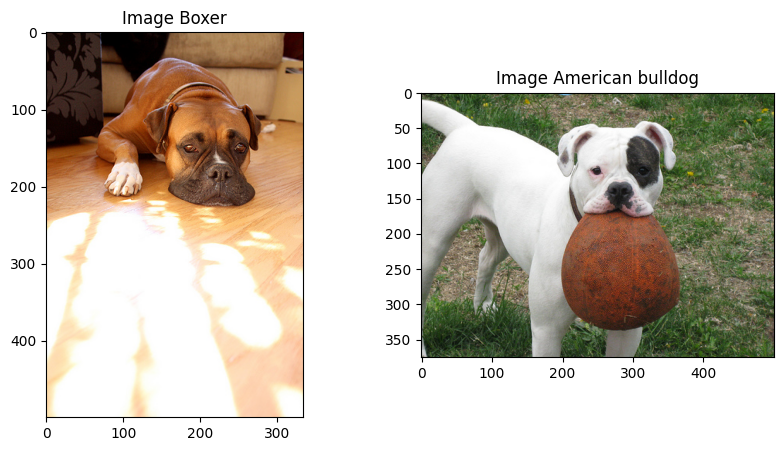

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 ligne, 2 colonnes

boxer_df = test_df[test_df['class'] == "boxer"]
filename = boxer_df['image'].iloc[3]
img1 = img_to_array(load_img(path_images + filename) ) / 255

axes[0].imshow(img1)
axes[0].set_title("Image Boxer") 

american_df = test_df[test_df['class'] == "american_bulldog"]
filename2 = american_df['image'].iloc[4]
img2 = img_to_array(load_img(path_images + filename2) ) / 255

axes[1].imshow(img2)
axes[1].set_title("Image American bulldog") 
plt.show()

Les chiens se ressemblent beaucoup plus que l'american bulldog et le beagle, pouratnt le modèle confodn beaucoup moins les deux races. Cependant, il n'arrive pas bien à prédire la race boxer au vu de la matrice de confusion et sachant qu'il y a 21 images de boxer.

## Segmentation des animaux 

### Implémentation du réseau de type U-Net

Dans cette partie, nous allons nous intéresser à la segmentation des chiens et des chats grâce à un réseau U-Net: cela signifie que nous allons attribuer une "étiquette" (label) à chaque pixel de notre image, 1 pour l'animal et 0 pour le fond. 

Le modèle U-Net est un type de réseau de neurones convolutif. Son nom vient du fait qu'il suit une architecture en forme de “U”, en deux parties : une partie descendante (encoder) qui extrait des caractéristiques de plus en plus abstraites, et une partie montante (decoder) qui reconstruit une image segmentée de la même taille que l’entrée. 

Dans la segmentation d’images de chiens ou de chats, ce réseau U-Net nous permet de prédire, pour chaque pixel, s’il appartient à l’animal ou au fond. Le modèle apprend à reconnaître les contours, la forme du corps, la texture du pelage, ..., et génère un masque séparant l’animal du reste de l’image. U-Net est particulièrement efficace pour obtenir des segmentations nettes même lorsque les formes sont complexes ou les fonds variés.
On commence donc par préparer les images pour notre segmentation.

In [28]:
# SEGMENTATION D'ANIMAUX AVEC U-NET
# PARAMÈTRES GÉNÉRAUX

img_width = img_height = 128   # Test de taille uniforme mais pas convaincue par la taille, voir si amélioration possible
batch_size = 20

path_images = "./images/"
path_masks  = "./annotations/trimaps/"


# Split train / val / test
train_df = df.sample(frac=0.7, random_state=42)
temp_df  = df.drop(train_df.index)
validation_df = temp_df.sample(frac=0.5, random_state=42)
test_df = temp_df.drop(validation_df.index)


In [29]:
# GÉNÉRATEURS IMAGES + MASQUES

def image_generator(df, path_images, batch_size=8):
    while True:
        # Shuffle à chaque epoch pour éviter que le modèle s'habitue à l'ordre des images
        df_shuffled = df.sample(frac=1).reset_index(drop=True)
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            imgs = []
            for fname in batch_df['image']:
                img = np.array(
                    Image.open(path_images + fname)
                    .resize((img_width,img_height))
                    .convert("RGB")          # cela nous garantit 3 canaux
                )
                img = img / 255.0
                imgs.append(img)
            yield np.array(imgs, dtype=np.float32)


def mask_generator(df, path_masks, batch_size=8):
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            masks = []
            for fname in batch_df['image']:
                mask = np.array(
                    Image.open(path_masks + fname.replace('.jpg','.png'))
                    .resize((img_width,img_height))
                    .convert("L")            # niveaux de gris = 1 canal
                )
                # Binarisation : 1 = animal, 0 = fond
                mask_binary = np.where(mask == 1, 1, 0)[..., np.newaxis]
                masks.append(mask_binary)
            yield np.array(masks, dtype=np.float32)


# Fusionner les deux générateurs pour créer (image, masque)
def combined_generator(df, path_images, path_masks, batch_size=8):
    img_gen = image_generator(df, path_images, batch_size)
    mask_gen = mask_generator(df, path_masks, batch_size)
    while True:
        imgs = next(img_gen)
        masks = next(mask_gen)
        yield imgs, masks

In [30]:
# Train et Validation generators
train_generator      = combined_generator(train_df, path_images, path_masks, batch_size)
validation_generator = combined_generator(validation_df, path_images, path_masks, batch_size)
test_generator       = combined_generator(test_df, path_images, path_masks, batch_size)

Ce modèle U-Net commence par une entrée composée de trois canaux d’image. La première partie du réseau est l'encodeur : elle applique deux fois de suite des convolutions avec une activation relu pour extraire des motifs locaux, puis réduit la résolution grâce à un pooling. Cette opération est répétée trois fois, avec un nombre de filtres qui augmente à chaque niveau, d’abord 16, puis 32, puis 64. Chaque descente dans l’encodeur réduit la taille spatiale de l’image.

Une fois arrivé au niveau le plus profond, le réseau fait deux convolutions supplémentaires avec 128 filtres. Cette zone centrale est comme un "goulot" où les caractéristiques les plus abstraites sont apprises.

La partie suivante correspond au décodeur. À chaque étape, on augmente la résolution grâce à un upsampling, puis on concatène la sortie. On réintroduit alors les informations spatiales fines qui auraient pu être perdues pendant le pooling. Après la concaténation, deux nouvelles convolutions avec une activation relu sont appliquées pour fusionner les informations. Le nombre de filtres diminue, en "miroir" de l’encodeur, passant de 64 à 32 puis à 16.

À la fin du réseau, une dernière convolution avec un filtre unique et une activation sigmoïde produit une carte de sortie à un seul canal (logique puisque nous voulons un masque noir et blanc). Cette carte représente typiquement une probabilité par pixel, en l'occurence pour une tâche de segmentation binaire (présence de l'animal ou non). Enfin, le modèle est compilé avec l’optimiseur Adam, un taux d’apprentissage faible (1e-4) et une perte d’entropie croisée binaire.aptée à une segmentation binaire.

---


In [31]:
# Modèle U-NET

def unet(input_size=(img_width, img_height, 3)):
    inputs = Input(input_size)

    # --- Encodeur ---
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    # --- Bottleneck ---
    c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    # --- Decodeur ---
    u5 = UpSampling2D()(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = UpSampling2D()(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D()(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

In [32]:
model = unet()
model.compile(optimizer=Adam(1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 16)      │             448 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 128, 128, 16)      │           2,320 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 64, 64, 16)        │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 32)        │           4,640 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 64, 64, 32)        │           9,248 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 32, 32, 32)        │               0 │ conv2d_6[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 64)        │          18,496 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 32, 32, 64)        │          36,928 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 16, 16, 64)        │               0 │ conv2d_8[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 16, 16, 128)       │          73,856 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 16, 16, 128)       │         147,584 │ conv2d_9[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 32, 32, 128)       │               0 │ conv2d_10[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 32, 32, 192)       │               0 │ up_sampling2d[0][0],       │
│                               │                           │                 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 32, 32, 64)        │         110,656 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# ENTRAÎNEMENT

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(validation_df) // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=20
)

Epoch 1/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.8767 - loss: 0.2842 - val_accuracy: 0.8771 - val_loss: 0.2902
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 250s 968ms/step - accuracy: 0.8793 - loss: 0.2786 - val_accuracy: 0.8765 - val_loss: 0.2885
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8822 - loss: 0.2723 - val_accuracy: 0.8731 - val_loss: 0.2946
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.8849 - loss: 0.2665 - val_accuracy: 0.8692 - val_loss: 0.3033
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 256s 993ms/step - accuracy: 0.8874 - loss: 0.2612 - val_accuracy: 0.8677 - val_loss: 0.3078
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.8894 - loss: 0.2570 - val_accuracy: 0.8783 - val_loss: 0.2861
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 253s 982ms/step - accuracy: 0.8917 - loss: 0.2521 - val_accuracy: 0.8874 - val_loss: 0.2667
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 254s 983ms/step - accuracy: 0.8934 - loss: 0.248

Le **IoU (Intersection over Union)** et le **Dice coefficient** sont deux métriques utilisées pour évaluer la qualité d’une segmentation faite par un réseau de neurones.  
Le IoU mesure le rapport entre l’intersection et l’union du masque prédit et du masque réel, ce qui en fait une métrique assez stricte :

$$
\mathrm{IoU} \;=\; \frac{|A \cap B|}{|A \cup B|}
$$

Le **Dice**, plus indulgent, met un peu plus l’accent sur le recouvrement entre les deux masques :

$$
\mathrm{Dice} \;=\; \frac{2\,|A \cap B|}{|A| + |B|}
$$

Ces deux métriques indiquent dans quelle mesure le modèle segmente correctement l’animal. Dans la segmentation de chiens ou de chats, un bon modèle obtient généralement un **IoU** entre **0.60–0.80** et un **Dice** entre **0.75–0.90**, reflétant des contours précis et peu d’erreurs pixel par pixel.

In [37]:
# MÉTRIQUES DE SEGMENTATION

def iou(y_true, y_pred, smooth=1e-6):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


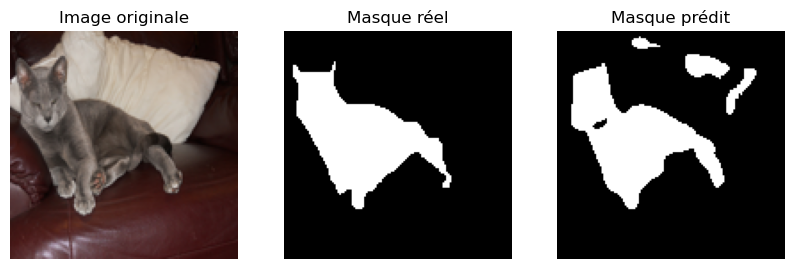

IoU: 0.7595762
Dice: 0.86336267


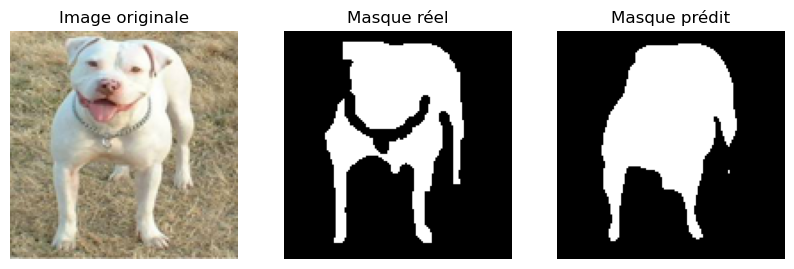

IoU: 0.7595762
Dice: 0.86336267


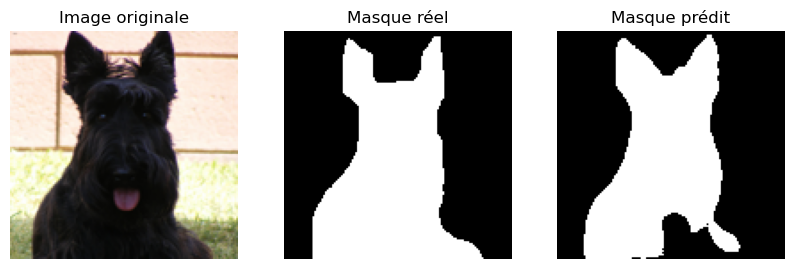

IoU: 0.7595762
Dice: 0.86336267


In [38]:
# VISUALISATION DE RÉSULTATS

imgs, masks = next(train_generator)
preds = model.predict(imgs[:3])

for i in range(3):
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(imgs[i])
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(masks[i,:,:,0], cmap="gray")
    plt.title("Masque réel")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(preds[i,:,:,0] > 0.5, cmap="gray")
    plt.title("Masque prédit")
    plt.axis("off")

    plt.show()

    print("IoU:", iou(masks[:1], preds[:1]).numpy())
    print("Dice:", dice_coef(masks[:1], preds[:1]).numpy())

Ici, on voit ainsi que notre modèle rentre parfaitement dans ces cases car le IoU est de 0.76 et le dice de 0.86. Ce résultat peut certainement être amélioré en augmentant le nombre d'epoch (ici seulement 20), même si le temps d'entraînement s'en trouve augmenté aussi (il faut plus de deux heures au réseau pour parvenir au bout des vingt epochs).el par pixel.

## Analyse Comparative

Dans cette partie, on s'interesse au comportement du modèle U-net en fonction de la race. On cherche donc notemment à répondre aux questions suivantes : 
- Est-ce que certaines races sont mieux segmentées que d'autres ? 
- Est ce qu'il est plus facile de segmenter un chien ou un chat ? 

Idée : Nous vennons d'entraîner un modèle de type U-net sur nos données. L'objectif et de déterminer si ce dernier présente des biais dans sa reconnaissance et sa segmentation des animaux.
On va donc considérer toutes les images de la base de donnée de test, les passer dans le modèle et récupérer les scores IoU et DICE pour les analyser. 

In [ ]:
# Tableau récapitulatif des performanes par images

liste_results = []

for i in range(len(test_df)):
    #Récupération des informations associées à l'image courante
    filename    = test_df['image'].iloc[i]
    race        = test_df['class'].iloc[i]     # nom de la race
    animal_type = test_df['animal'].iloc[i]      # "cat" ou "dog"

    # Chargement de l'image
    img = np.array(
        Image.open(os.path.join(path_images, filename))
        .resize((img_width, img_height))
        .convert("RGB")
    ) / 255.0
    img = np.expand_dims(img, axis=0)  # (1, H, W, 3)

    # Chargement du masque réel associé
    mask = np.array(
        Image.open(os.path.join(path_masks, filename.replace('.jpg', '.png')))
        .resize((img_width, img_height), resample=Image.NEAREST)
        .convert("L")
    )
    # Binarisation du masque : on prépare le masque à être de la même forme que la sortie pour pouvoir comparer
    # 1 = animal, 2 = fond, 3 = non classifié  --> binaire : animal = 1, le reste = 0
    mask_binary = np.where(mask == 1, 1.0, 0.0)[..., np.newaxis].astype(np.float32)  # (H, W, 1)
    mask_binary = np.expand_dims(mask_binary, axis=0)  # (1, H, W, 1)


    # Prédiction de la segmentation en appelant le modèle Unet entraîné précedement
    pred = model.predict(img, verbose = 0)  # (1, H, W, 1)

    # Calcul des scores
    iou_score  = float(iou(mask_binary, pred).numpy())
    dice_score = float(dice_coef(mask_binary, pred).numpy())

    # Stockage des information
    liste_results.append({
        "image": filename,
        "race": race,             
        "animal": animal_type,
        "iou": iou_score,
        "dice": dice_score
    })
# Conversion en dataframe pour les manipulations
results_df = pd.DataFrame(liste_results)

# Première visualisation
results_df.head()


### Analyse comparative par race

In [ ]:
# Est ce que certaines races sont plus difficiles à segmenter que d'autres ?

# 1) Calcul de statistique sur les IoU par race
stats_race = results_df.groupby("race").agg(
    mean_iou   = ("iou", "mean"),
    median_iou = ("iou", "median"),
    std_iou    = ("iou", "std"),
    mean_dice  = ("dice", "mean"),
    count      = ("iou", "count")
).reset_index()

# 2) Trier pour voir les meilleures/pire races
# Comme les effectifs sont proches les moyennes sont peu influencées
stats_race_trie = stats_race.sort_values(by="mean_iou", ascending=False)

# 3) Visualisation : barplot des IoU moyens par race
plt.figure(figsize=(12, 5))
plt.bar(stats_race_trie["race"], stats_race_trie["mean_iou"])
plt.xticks(rotation=90)
plt.ylabel("IoU moyen")
plt.title("IoU moyen par race")
plt.tight_layout()
plt.show()


On observe que la segmentation semble dépendre de la race. regardons en détails les 5 moins bien segementées les 5 le mieux segmentées. 

In [ ]:
# Focus sur les 5 meilleures et les 5 pires races
top  = stats_race_trie.head(5)
worst = stats_race_trie.tail(5)
plt.figure(figsize=(12, 5))
plt.bar(top["race"], top["mean_iou"], color='seagreen', label='Top 5')
plt.bar(worst["race"], worst["mean_iou"], color='salmon', label='Worst 5')
plt.xticks(rotation=90)
plt.ylabel("IoU moyen")
plt.title("Top 5 et Worst 5 des races par IoU moyen")
plt.legend()
plt.tight_layout()
plt.show()

On rappel que l'on cherche à savoir si les performances de segmentation (mesurées par l'IoU) dépendent de la race de l’animal ? Pour cela nous comparons donc plusieurs groupes. Or les scores d’IoU étant bornés entre 0 et 1 et présentant des distributions non gaussiennes,   l’anayse de varaince ANOVA n’est pas appropriée.

Nous avons donc opté pour le test de Kruskal–Wallis (test de H), un test non paramétrique adapté à la comparaison de plusieurs groupes.
H0 : Les échantillons indépendants ont tous la même tendance centrale et proviennent donc de la même population. 
H1 : Au moins un des échantillons indépendants n'a pas la même tendance centrale que les autres échantillons et provient donc d'une population différente.

Ainsi, si p < 0.05, l’hypothèse nulle est rejetée et on peut donc considérer que les groupes présentes une différence significative. Dans notre cas cela impliquerait que les IoU sont significativement différentes entre les races et donc que le modèle ne segmente pas avec la même qualité. 
Si p ≥ 0.05, nous ne disposons pas de preuves suffisantes pour rejeter l’hypothèse nulle, aucune différence significative n’est détectée et donc on ne peut pas affirmer que l'IoU dépend de la race. 

https://numiqo.fr/tutorial/kruskal-wallis-test
https://fr.wikipedia.org/wiki/Test_de_Kruskal-Wallis


In [ ]:
groups = [results_df[results_df["race"] == r]["iou"] for r in results_df["race"].unique()]

stat, p = kruskal(*groups)

print("Kruskal-Wallis H test : p =", p)
if p < 0.05:
    print("→ Il existe une différence significative entre les races.")
else:
    print("→ Aucune différence significative détectée entre les races.")


On a donc confirmation que la qualité de la segmentation dépend des races. Cependant le test ne nous permet pas d'identifier les races concernées ni pour combien de paires de races. 

On utilise alors le test de Dunn avec correction de Bonferroni. Ce test compare les distributions des IoU entre chaque paire de races en se basant sur les rangs plutot que les valeurs d'Iou, et la correction de Bonferroni permet de contrôler le risque d’erreur de type I malgré le grand nombre de comparaisons.

In [ ]:
dunn = sp.posthoc_dunn(
    results_df, 
    val_col="iou", 
    group_col="race", 
    p_adjust="bonferroni"
)

dunn.head()

In [ ]:
#Visualisation des liens entre les races
plt.figure(figsize=(12,10))
sns.heatmap(dunn, cmap="viridis", annot=False)
plt.title("Matrice des p-values (post-hoc Dunn)")
plt.show()

La heatmap ci-dessus représente la matrice des p-valeurs obtenu par le test de Dunn. L'encodage de l'intensité des p-valeurs permet d'observer les paires de races qui présente une différence de qualité de segmentation importante. 

Les couleurs claires traduisent une p-valeur élevée au test ce qui indique une absence de différence. En revanche les couleurs sombres indiquent une p-valeur faible ce qui traduit une différence significative. 

On identifie donc les races qui sont moins bien segmenter par le modèle et on retrouve les Bengal et les Egyptian-Mau observés plus tôt.

### Analyse comparative par type d'animal : Chat vs Chien

In [ ]:
#Est ce qu'il est plus facile de segmenter les chats ou les chiens ?
# Statistiques de l'IoU par type d'animal
stats_type = results_df.groupby("animal").agg(
    mean_iou   = ("iou", "mean"),
    median_iou = ("iou", "median"),
    std_iou    = ("iou", "std"),
    mean_dice  = ("dice", "mean"),
    count      = ("iou", "count")
).reset_index()

print(stats_type)   

# Visualisation : barplot des IoU moyens par type d'animal : pour visualiser la distribution des moyennes
plt.figure(figsize=(6, 5))
plt.bar(stats_type["animal"], stats_type["mean_iou"], color=['pink', 'lightblue'])
#plt.bar(stats_type["type"], stats_type["mean_iou"], color=["#ffb6c1", "#add8e6"])
plt.ylabel("IoU moyen")
plt.title("IoU moyen par type d'animal")
plt.tight_layout()
plt.show()  

# Visualisation : boxplot des IoU par type d'animal
plt.figure(figsize=(6, 5))
sns.boxplot(x="animal", y="iou", data=results_df, palette=['pink', 'lightblue'])
plt.ylabel("IoU")
plt.title("Distribution des IoU par type d'animal")
plt.tight_layout()
plt.show() 


In [ ]:
# Histogrammes des IoU pour les chats et les chiens
#Pour vérifier si c'est gaussien ou pas
iou_chats = results_df[results_df["animal"] == "cat"]["iou"]
iou_chiens = results_df[results_df["animal"] == "dog"]["iou"]


plt.figure(figsize=(12, 5))
sns.histplot(iou_chats, kde=True, color="pink")
plt.title("Distribution IoU - Chats")
plt.show()

sns.histplot(iou_chiens, kde=True, color="lightblue")
plt.title("Distribution IoU - Chiens")
plt.show()


On constate que les IoU ne sont pas gaussienne et ont une distribution 
Dans la segmentation :
les IoU sont souvent pas du tout gaussiens
distribution souvent asymétrique (beaucoup de bons IoU + quelques mauvais)

On cherche à comparer la distribution des deux moyennes : 

H0 : les iou ont la meme loi - le type d'animal n'a pas d'influence 

H1 : les moyennes sont différentes - le type d'animal à une influence 

In [ ]:
#QQ-plot des IoU pour les chats et les chiens

stats.probplot(iou_chats, dist="norm", plot=plt)
plt.title("QQ-plot IoU - Chats")
plt.show()

stats.probplot(iou_chiens, dist="norm", plot=plt)
plt.title("QQ-plot IoU - Chiens")
plt.show()


Les QQ-plots confirment l'observation faites des graphiques des distributions. Les deux ne sont pas gausiennes. 

In [ ]:
#Si gaussien on peut faire un t-test, sinon un test de mann-whitney

# Mann-Whitney U test
stat, p_value = mannwhitneyu(iou_chats, iou_chiens)
print("Mann-Whitney U test entre IoU des chats et des chiens : stat=%.3f, p=%.3f" % (stat, p_value))
if p_value < 0.05:
    print("Différence significative entre les IoU des chats et des chiens (p < 0.05)")
else:
    print("Pas de différence significative entre les IoU des chats et des chiens (p >= 0.05)")
